# ASCB Demo -- TNNI1

----------------------------------------
key steps of the workflow:
* Auto-contrast
* Edge-preserving smoothing
* 3D filament filter 
* Size filter

In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)

## Loading the data

In [2]:
FILE_NAME =  '../demo_data/TNNI1_demo_data.tif'
reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

(1, 1, 1, 60, 441, 555)


## Preview of the image

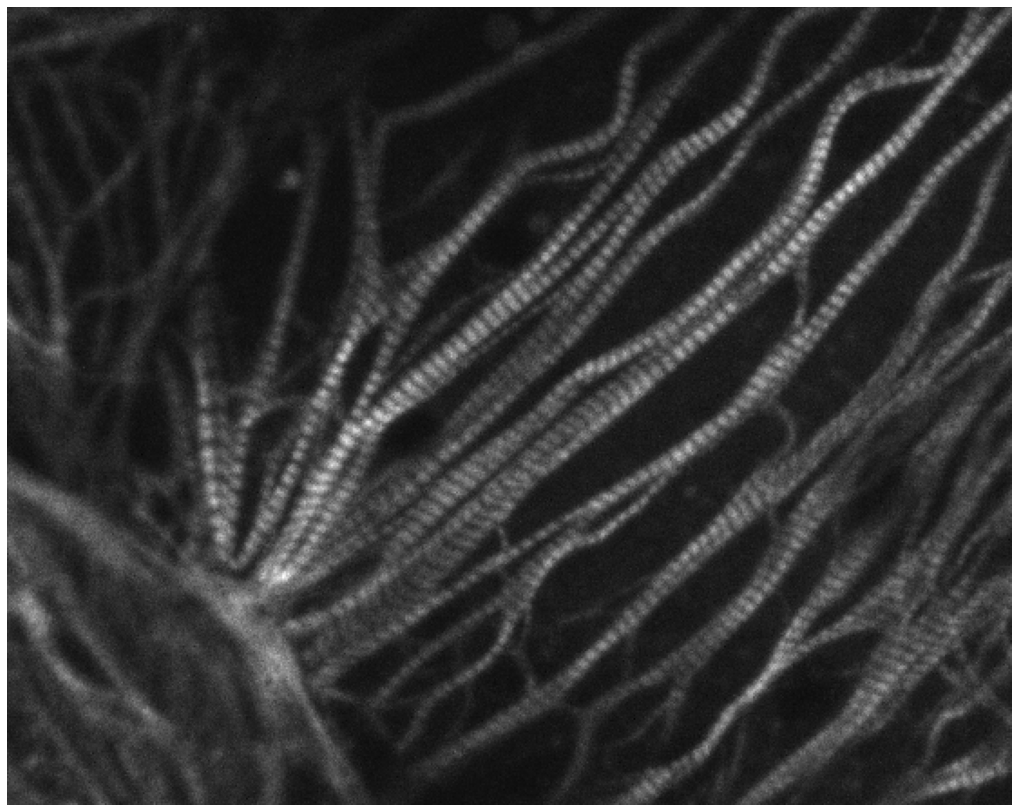

In [3]:
N_CHANNELS = IMG.shape[2]
MID_SLICE = np.int(0.5*IMG.shape[3])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
## PARAMETER ##
structure_channel = 0
#####################

structure_img0 = IMG[0,0,structure_channel,:,:,:].astype(np.float32)
view(single_fluorescent_view(structure_img0))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**

Parameter:  `intensity_scaling_param = [2, 11]`

About this parameter `intensity_scaling_param = [A, B]`: Here, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be.
 

* **Smoothing** 

Edge-preserving smoothing, no parameter

In [5]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [2, 11]
################################

# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing with edge preserving smoothing 
structure_img_smooth = edge_preserving_smoothing_3d(structure_img)

In [6]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = `

In [7]:
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(structure_img0)

mean intensity of the stack: 137.08570861816406
the standard deviation of intensity of the stack: 54.540889739990234
0.9999 percentile of the stack intensity is: 693.0
minimum intensity of the stack: 34.0
maximum intensity of the stack: 737.3627319335938
suggested upper range is 10.5, which is 709.7650508880615
suggested lower range is 1.5, which is 55.27437400817871
So, suggested parameter for normalization is [1.5, 10.5]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### Apply F3 filter
Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated thickness of your target filaments. For example, if visually the thickness of the filaments is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have filaments of very different thickness.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more filaments, especially detecting more dim ones and thicker segmentation, while larger `cutoff_x` could be less permisive and yield less filaments and slimmer segmentation.

In [8]:
################################
## PARAMETERS for this step ##
f3_param = [[1, 0.01]]
################################

bw = filament_3d_wrapper(structure_img_smooth, f3_param)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [9]:
# check the result of default parameters
view(segmentation_quick_view(bw))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [10]:
# Find a region of interest (ROI) in segmentation image above, and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [246, 146, 363, 242]
view(seg_fluo_side_by_side(structure_img,bw,roi=['M',ROI]))

# or comment out the following line to see the whole FOV
# view(seg_fluo_side_by_side(structure_img,bw, roi=['Full', None]))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

#### If the segmentation is satisfactory, go to Step 3; otherwise, you can tune parameters to improve the performance. Follow the steps below:

--------------------------
1. If you see lots of mis-detection --> try to decrease `cutoff`
2. If the algorithm detects too much, much thicker than it should be or lots of background noise --> try to increase `cutoff`
3. If the algorithm only detects all those major filaments (i.e., missing tenuous filaments) --> try use or add a smaller `scale`
4. If the major filaments are detected as over fragmented --> try use or add a larger `scale`
------------------------------

#### Step 3: Post-Processing 

In [11]:
################################
## PARAMETERS for this step ##
minArea = 20
################################

final_seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [12]:
view(seg_fluo_side_by_side(structure_img,final_seg))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

### You can also focus your inspection on a small ROI

In [13]:
# Find ROI in segmentation image above (not the raw image on the right part), and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_righ|t_X, Lower_right_Y]
ROI = [200, 200, 300, 370]
view(seg_fluo_side_by_side(structure_img, final_seg, roi=['M', ROI]))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

### You may also physically save the segmentation results into a .tiff file

In [15]:
final_seg= final_seg>0
out=final_seg.astype(np.uint8)
out[out>0]=255
writer = OmeTiffWriter('test_segmentation_TNNI1.tiff')
writer.save(out)